# Hybrid Method-Recursive Feature Elimination Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
data=pd.read_csv('/Users/shailendrapatil/Fall2017/Machine Learning A-Z Template Folder/Projects/House Price Advanced Regression Techniques/train.csv')
data.shape

(1460, 81)

In [3]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

(1460, 38)

In [5]:
data.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(labels=['SalePrice', 'Id'], axis=1),
                                                    data['SalePrice'],
                                                    test_size=0.3,
                                                    random_state=0)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(1022, 36) (1022,)
(438, 36) (438,)


In [8]:
seed_val = 1000000000
np.random.seed(seed_val)

In [9]:
import xgboost as xgb

In [10]:
from sklearn.metrics import r2_score

#### the first step of this procedure consists in building a machine learning algorithm using all the available features and then determine the importance of the features according to the algorithm

In [11]:
model_all_features = xgb.XGBRegressor(
    nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05,n_jobs=-1)

In [12]:
model_all_features.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=-1, nthread=10, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Calculate R2

In [13]:
y_pred_test = model_all_features.predict(X_test)
r2_score_all = r2_score(y_test, y_pred_test)
print('Test all features xgb R2 = %f' % (r2_score_all))

Test all features xgb R2 = 0.818551


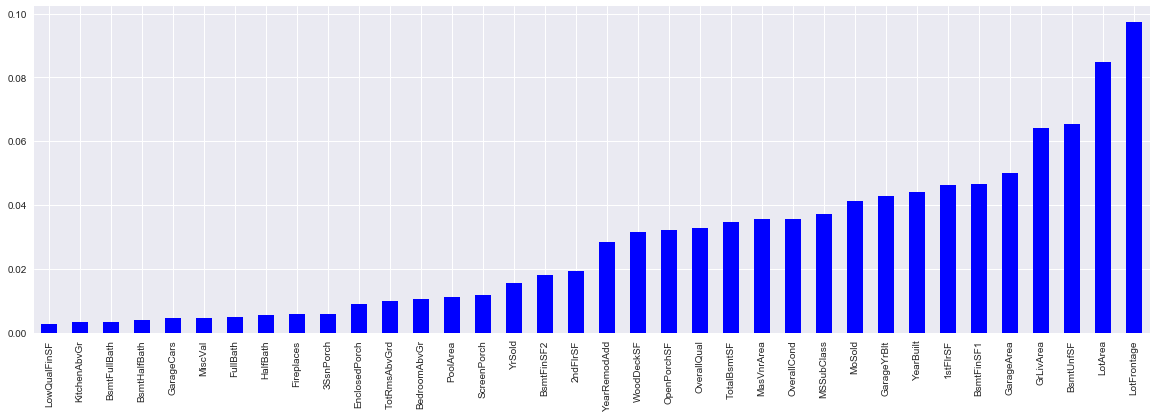

In [14]:
features = pd.Series(model_all_features.feature_importances_)
features.index = X_train.columns
 
# sort the features by importance
features.sort_values(ascending=True, inplace=True)
 
# plot
features.plot.bar(figsize=(20,6),color='blue')

In [15]:
features = list(features.index)

#### the final step consists in removing one at a time all the features, from the least to the most important, and build an xgboost at each round. once we build the model, we calculate the new r2 if the new r2 is smaller than the original one (with all the features), then that feature that was removed was important, and we should keep it. otherwise, we should remove the feature

In [16]:
tol=0.001

In [17]:
features_to_remove = []
 

In [18]:
count = 1


In [19]:
for feature in features:
    print()
    print('testing feature: ', feature, ' which is feature ', count,
          ' out of ', len(features))
    count = count + 1
 
    # initialise model
    model_int = xgb.XGBRegressor(
        nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05,n_jobs=-1)
 
    # fit model with all variables minus the removed features
    # and the feature to be evaluated
    model_int.fit(
        X_train.drop(features_to_remove + [feature], axis=1), y_train)
 
    # make a prediction over the test set
    y_pred_test = model_int.predict(
        X_test.drop(features_to_remove + [feature], axis=1))
 
    # calculate the new r2
    r2_score_int = r2_score(y_test, y_pred_test)
    print('New Test r2 = {}'.format((r2_score_int)))
 
    # print the original r2 with all the features
    print('All features Test r2 = {}'.format((r2_score_all)))
 
    # determine the drop in the r2
    diff_r2 = r2_score_all - r2_score_int
 
    # compare the drop in r2 with the tolerance
    # we set previously
    if diff_r2 >= tol:
        print('Drop in r2 ={}'.format(diff_r2))
        print('keep: ', feature)
        print
    else:
        print('Drop in r2 = {}'.format(diff_r2))
        print('remove: ', feature)
        print
        # if the drop in the r2 is small and we remove the
        # feature, we need to set the new r2 to the one based on
        # the remaining features
        r2_score_all = r2_score_int
        
        # and append the feature to remove to the collecting
        # list
        features_to_remove.append(feature)


testing feature:  LowQualFinSF  which is feature  1  out of  36
New Test r2 = 0.8176628877400767
All features Test r2 = 0.8185508615101988
Drop in r2 = 0.0008879737701221746
remove:  LowQualFinSF

testing feature:  KitchenAbvGr  which is feature  2  out of  36
New Test r2 = 0.8218740628640144
All features Test r2 = 0.8176628877400767
Drop in r2 = -0.00421117512393776
remove:  KitchenAbvGr

testing feature:  BsmtFullBath  which is feature  3  out of  36
New Test r2 = 0.8216199474312881
All features Test r2 = 0.8218740628640144
Drop in r2 = 0.00025411543272635395
remove:  BsmtFullBath

testing feature:  BsmtHalfBath  which is feature  4  out of  36
New Test r2 = 0.8241857928140686
All features Test r2 = 0.8216199474312881
Drop in r2 = -0.002565845382780485
remove:  BsmtHalfBath

testing feature:  GarageCars  which is feature  5  out of  36
New Test r2 = 0.8234478263522329
All features Test r2 = 0.8241857928140686
Drop in r2 = 0.0007379664618356596
remove:  GarageCars

testing feature:  

In [20]:
print('DONE!!')
print('total features to remove: ', len(features_to_remove))

DONE!!
total features to remove:  13


#### capture the 23 selected features

In [21]:
features_to_keep = [x for x in features if x not in features_to_remove]
print('total features to keep: ', len(features_to_keep))

total features to keep:  23


Lets test the model on test set

In [22]:
seed_val = 1000000000
np.random.seed(seed_val)
 
# build initial model
final_xgb = xgb.XGBRegressor(
    nthread=10, max_depth=4, n_estimators=500, learning_rate=0.05,n_jobs=-1)
 
# fit the model with the selected features
final_xgb.fit(X_train[features_to_keep], y_train)
 
# make predictions
y_pred_test = final_xgb.predict(X_test[features_to_keep])
 
# calculate roc-auc
r2_score_final = r2_score(y_test, y_pred_test)
print('Test selected features r2 = %f' % (r2_score_final))
print('Test all features r2 = %f' % (r2_score_all))

Test selected features r2 = 0.863848
Test all features r2 = 0.887428
